In [1]:
# Preliminary data generation
import scipy as sp
import numpy as np
import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
import scipy.sparse
import scipy.sparse.linalg
import theano as T
import theano.tensor as tt
import pymc3 as pm
import seaborn as sbn
np.set_printoptions(precision=3, suppress=True)
# there are some FutureWarnings from theano.Tensor
import warnings
warnings.filterwarnings('ignore')

np.random.seed(314159)

n = 250
k_true = 5
d = 9
err_sd = 2
N_SAMPLE = 350
M = np.random.binomial(1, 0.25, size=(k_true, n))
Q = np.hstack([np.random.exponential(2*k_true - k, size=(d, 1)) for k in range(k_true)]) * np.random.binomial(1, 0.75, size=(d, k_true))
Y = np.round(1000 * np.dot(Q, M) + np.random.normal(size=(d, n)) * err_sd)/1000

print(np.sum(Q, axis=0))
Y[:3,:7]

[81.791 43.265 45.045 35.098 26.493]


array([[ 0.406,  0.   ,  5.074,  9.827,  0.41 , 15.139, -0.001],
       [ 0.003,  0.003, 14.975,  0.001,  0.   ,  8.635, -0.004],
       [-0.002,  0.001,  5.012, 19.101,  3.31 , 20.363, -0.001]])

## Identifiability and scalability in Bayesian Factor Analysis

Probabilistic PCA and Bayesian Factor Analysis are a common source of posts in the pymc3 discourse:

`https://discourse.pymc.io/t/large-scale-factor-analysis-with-minibatch-advi/246`

`https://discourse.pymc.io/t/dealing-with-missing-data/252`

`https://discourse.pymc.io/t/unique-solution-for-probabilistic-pca/1324/14`

The model for factor analysis is the probabilistic matrix factorization

$X_{(d,n)}|W_{(d,k)}, F_{(k,n)} \sim N(WF, \Psi)$

with $\Psi$ a diagonal matrix. Subscripts denote the dimensionality of the matrices. Probabilistic PCA is a variant that sets $\Psi = \sigma^2I$. The basic implementation (taken from `https://gist.github.com/twiecki/c95578a6539d2098be2d83575e3d15fe`) is

Only 350 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 7,505:  24%|██▎       | 47434/200000 [00:30<01:44, 1455.03it/s]    
Convergence achieved at 47500
Interrupted at 47,499 [23%]: Average Loss = 33,309
Sequential sampling (4 chains in 1 job)
NUTS: [psi, F, W]
100%|██████████| 850/850 [00:06<00:00, 124.67it/s]
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


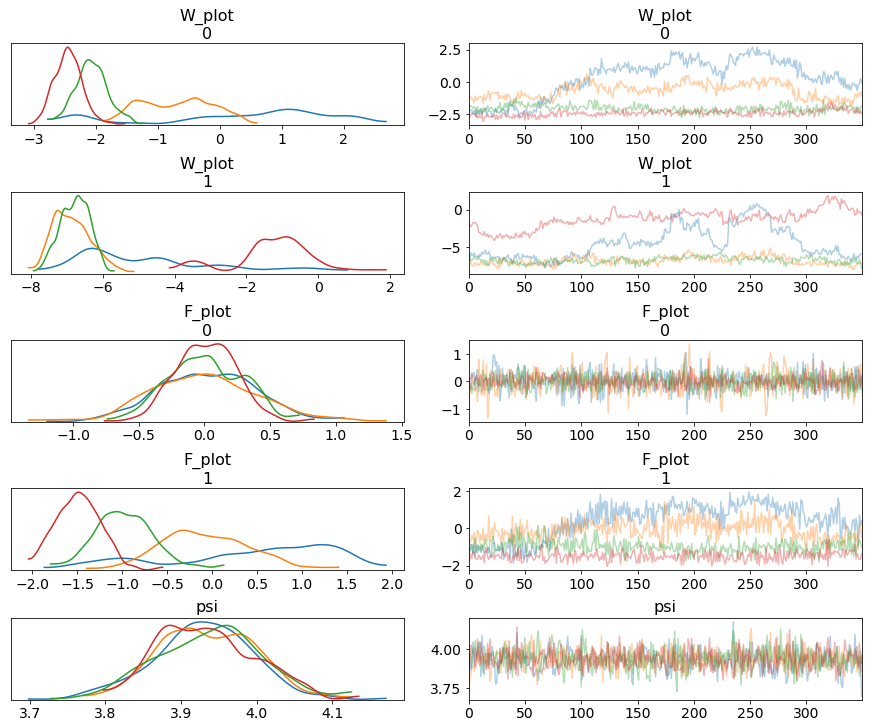

In [2]:
k=2
with pm.Model() as PPCA:
    W = pm.Normal('W', shape=(d,k))
    F = pm.Normal('F', shape=(k,n))
    psi = pm.HalfNormal('psi', 1.)
    X = pm.Normal('X', mu=tt.dot(W, F), sd=psi, observed=Y)
    # select a subset of weights and factors to plot
    W_plot = pm.Deterministic('W_plot', W[1:3,0])
    F_plot = pm.Deterministic('F_plot', F[0,1:3])
    
    trace = pm.sample(N_SAMPLE, chains=4, cores=1, init='advi+adapt_diag')

pm.traceplot(trace, ('W_plot', 'F_plot', 'psi'));

This approach suffers from two drawbacks: identifiability and scalability.

First, only the product $WF$ matters for the likelihood of $X$, so $P(X|W, F) = P(X|W\Omega, \Omega^{-1}F)$ for any invertible matrix $\Omega$. While the priors on $W$ and $F$ constrain $|\Omega|$ to be neither too large or too small, factors and loadings can still be rotated, reflected, and/or permuted *without changing the model likelihood*. Expect it to happen between runs of the sampler, or even for the parametrization to "drift" within run, and to produce the gobbeldygook W traceplot above.

This can be fixed by constraining the form of W to be:
  + Lower triangular
  + Positive, increasing diagonal
  
We can adapt `expand_block_triangular` to fill out a non-square matrix and then update our model:

Only 350 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 7,281.5:  16%|█▌        | 31084/200000 [00:24<02:47, 1010.21it/s]  
Convergence achieved at 31100
Interrupted at 31,099 [15%]: Average Loss = 44,409
Sequential sampling (4 chains in 1 job)
NUTS: [psi, F, W_b, W_z]
100%|██████████| 850/850 [00:15<00:00, 54.04it/s]
The number of effective samples is smaller than 25% for some parameters.


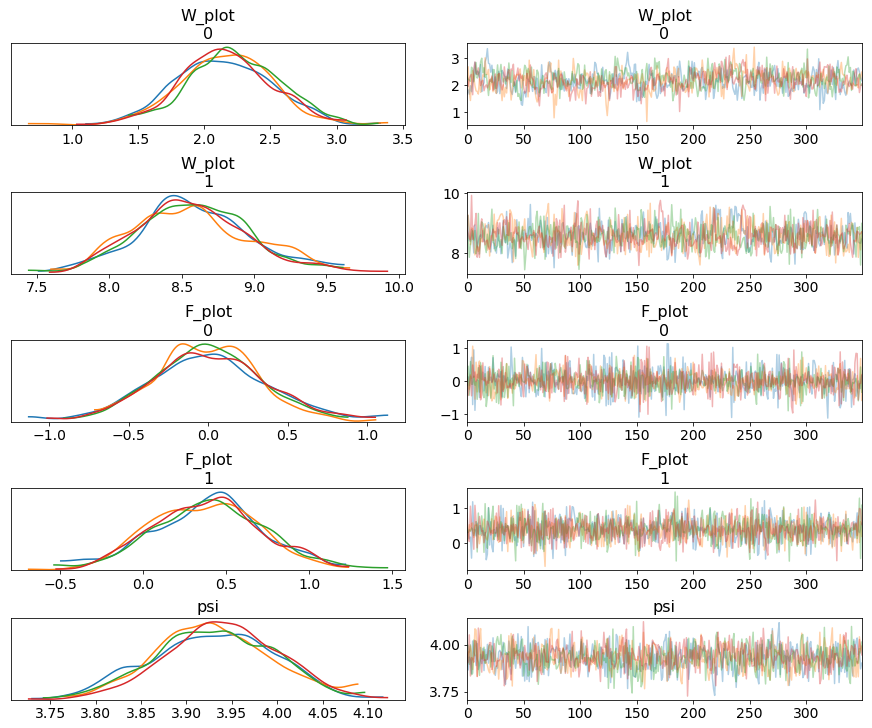

In [3]:
def expand_packed_block_triangular(n, k, packed, diag=None, mtype='theano'):
    # like expand_packed_triangular, but with n > k.
    assert mtype in {'theano', 'numpy'}
    assert n >= k
    def set_(M, i_, v_):
        if mtype == 'theano':
            return tt.set_subtensor(M[i_], v_)
        M[i_] = v_
        return M
    out = tt.zeros((n, k), dtype=float) if mtype == 'theano' else np.zeros((n,k), dtype=float)
    if diag is None:
        idxs = np.tril_indices(n, m=k)
        out = set_(out, idxs, packed)
    else:
        idxs = np.tril_indices(n, k=-1, m=k)
        out = set_(out, idxs, packed)
        idxs = (np.arange(k), np.arange(k))
        out = set_(out, idxs, diag)
    return out


def makeW(dat, k):
    # make a W matrix adapted to the data shape
    n_od = int(k*d - k*(k-1)/2 - k)
    z = pm.HalfNormal('W_z', 1., shape=(k,))  # trick: the cumulative sum of z will be positive increasing
    b = pm.Normal('W_b', 0., 1., shape=(n_od,))
    ones = tt.ones(k)
    L = pm.Deterministic('W_L', expand_packed_block_triangular(d, k, b, ones))
    W = pm.Deterministic('W', tt.dot(L, tt.diag(tt.extra_ops.cumsum(z))))
    return W


k=2
with pm.Model() as PPCA_identified:
    W = makeW(Y, k)
    F = pm.Normal('F', shape=(k,n))
    psi = pm.HalfNormal('psi', 1.)
    X = pm.Normal('X', mu=tt.dot(W, F), sd=psi, observed=Y)
    # select a subset of weights and factors to plot
    W_plot = pm.Deterministic('W_plot', W[1:3,0])
    F_plot = pm.Deterministic('F_plot', F[0,1:3])
    
    trace = pm.sample(N_SAMPLE, chains=4, cores=1, init='advi+adapt_diag')
    

pm.traceplot(trace, ('W_plot', 'F_plot', 'psi'));

W (and F!) now have consistent posterior distributions across runs of the sampler.

Because the $k \times n$ parameters in F all need to be sampled, sampling can become quite expensive for large large `n`. In addition, the link between an observed data point $X_i$ and an associated latent value $F_i$ means that mini-batching cannot be performed.

This scalability problem can be addressed analyitcally by integrating $F$ out of the model. However, this fixes the prior on $F$, allowing for no modeling flexibility. In keeping with $F_{ij} \sim N(0, 1)$ we have

$X|WF \sim \mathrm{MN}(WF, \Psi, I) \;\; F_{ij} \sim N(0, 1)$

$X|W \sim \mathrm{MN}(0, \Psi + WW^T, I)$

The explicit integration of $F$ also enables batching the observations for faster computation of ADVI and FullRankADVI approximations.

Average Loss = 1,547.9: 100%|██████████| 35000/35000 [01:43<00:00, 337.05it/s]
Finished [100%]: Average Loss = 1,547.9


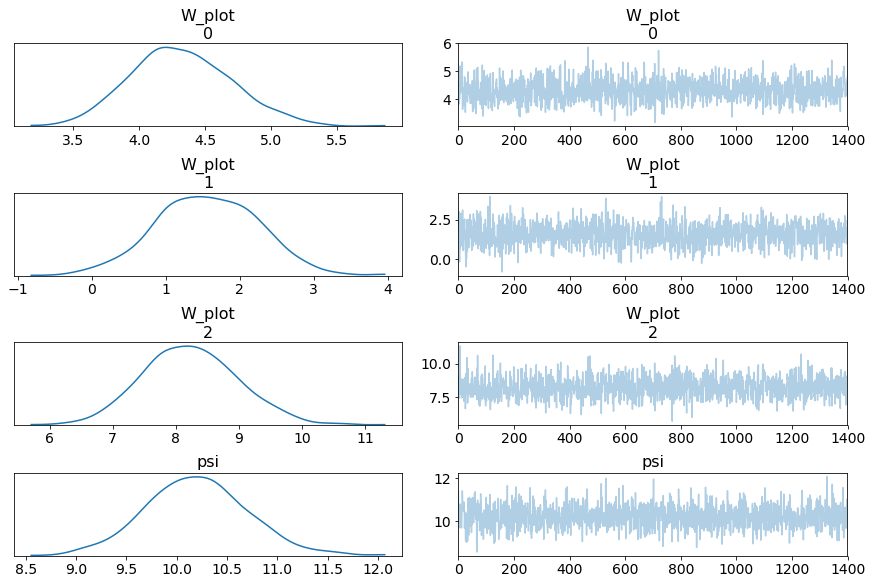

In [4]:
k=2
with pm.Model() as PPCA_scaling:
    W = makeW(Y, k)
    Y_mb = pm.Minibatch(Y.T, 50)  # MvNormal parametrizes covariance of columns, so transpose Y
    psi = pm.HalfNormal('psi', 1.)
    E = pm.Deterministic('cov', tt.dot(W, tt.transpose(W)) + psi * tt.diag(tt.ones(d)))
    X = pm.MvNormal('X', 0., cov=E, observed=Y_mb)
    W_plot = pm.Deterministic('W_plot', W[:3, 0])
    
    trace = pm.FullRankADVI().fit(35000, obj_n_mc=2).sample(N_SAMPLE*4)
    
pm.traceplot(trace, varnames=['W_plot', 'psi']);

### Post-hoc identification of F

The matrix $F$ is typically of interest for factor analysis, and is often used as a feature matrix for dimensionality reduction. However, $F$ has been marginalized away in order to make fitting the model easier; and now we need it back. This is, in effect, an exercise in least-squares as:

$X|WF \sim N(WF, \Psi)$

$(W^TW)^{-1}W^T\Psi^{-1/2}X|W,F \sim N(F, (W^TW)^{-1})$

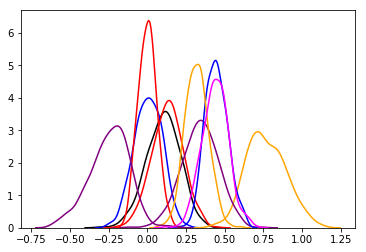

In [5]:
F_sampled = np.zeros((500, k, n))
for q in range(500):
    Wq = trace['W'][q,:,:]
    Pq = trace['psi'][q]
    WWq = np.linalg.inv(np.dot(Wq.T, Wq))
    Fq_mu = np.dot(1/np.sqrt(Pq) * np.dot(WWq, Wq.T), Y)
    WWq_chol = np.linalg.cholesky(WWq)
    F_sampled[q,:,:] = Fq_mu + np.dot(WWq_chol, np.random.normal(size=(k,n)))
    
cols = ['black', 'blue', 'red', 'orange', 'purple', 'magenta', 'green', 'yellow']
for i in range(2):
    for j in range(5):
        sbn.kdeplot(F_sampled[:, i, j], color = cols[(i + j) % len(cols)]);